## Install and import libraries

In [80]:
!pip install joblib
!pip install catboost
!pip install optuna
!pip install category_encoders
!pip install imblearn
!pip install xgboost

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import optuna


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as SamplerPipe
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score,
    balanced_accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix
)



from joblib import Parallel, delayed

In [82]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Rain Prediction in Australia

**Task Type**: Classification

**Metric to Optimize**: F1-Score

**Algorithms Used**:
- Gradient Boosting
- Random Forest
- Logistic Regression

## Read dataset

In [83]:
df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')

In [84]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Data overview

In [85]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

- **Total Rows:** 145,460
- **Total Columns:** 23

The dataset contains weather data collected from various meteorological stations located across Australia. These stations are spread across different locations, providing a diverse range of meteorological observations.

The data includes both **morning and afternoon measurements** for several weather parameters. Please note that there is a **significant amount of missing values** within the dataset, which may require data cleaning or imputation for analysis.

In [87]:
df['Date'] = pd.to_datetime(df.Date)
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['Year'] = df.Date.dt.year

In [88]:
value_types = df.dtypes
value_types = pd.DataFrame(value_types)
value_types.rename(columns={0: 'Type'}, inplace=True)
value_types = value_types.reset_index()
value_types = value_types.rename(columns={'index': 'Column'})

In [89]:
categorical_data = value_types[(value_types['Type'] == 'object') & (value_types['Column'] != 'Date')]
categorical_data = categorical_data['Column'].tolist()

categories_amount = pd.DataFrame(index=categorical_data, data=df[categorical_data].nunique(), columns=['Кол-во категории'])
categories_amount

,Кол-во категории
Location,49
WindGustDir,16
WindDir9am,16
WindDir3pm,16
RainToday,2
RainTomorrow,2


- **Number of Categorical Columns:** 6

- **Location:** 49 unique values

- **WindGustDir, WindDir9am, WindDir3pm:** Wind direction, each with 16 unique values

- **RainToday, RainTomorrow:** Binary features with 2 unique values (Yes, No)

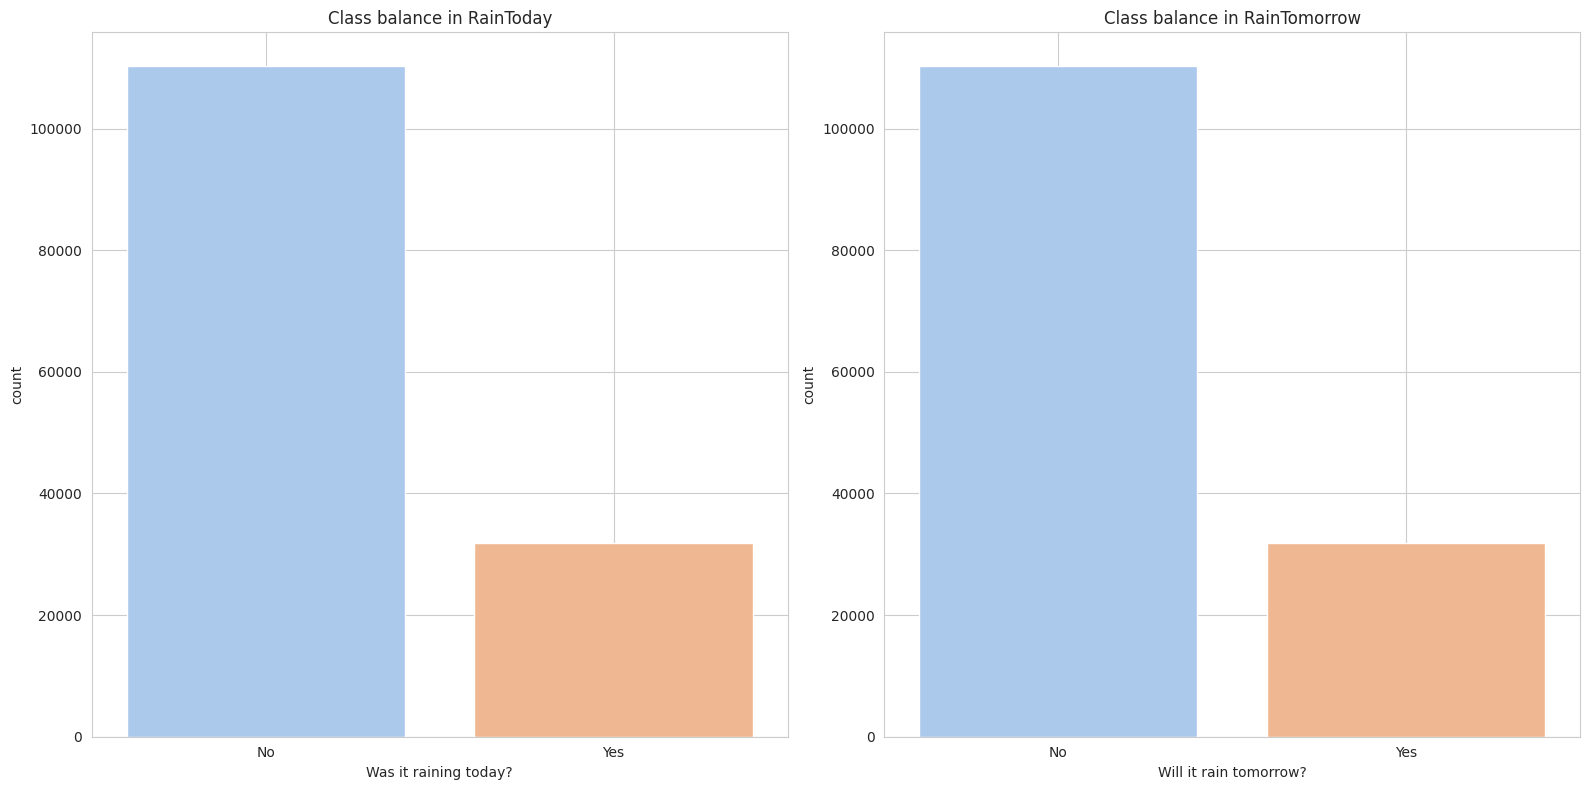

In [90]:
fig = plt.figure()

fig.set_size_inches(16, 8)



ax1 = fig.add_subplot(1,2, 1)
sns.countplot(data=df, x='RainToday')
ax1.set_title('Class balance in RainToday')
ax1.set_xlabel('Was it raining today?')
plt.grid(True)



ax2 = fig.add_subplot(1,2, 2)
sns.countplot(data=df, x='RainTomorrow')
ax2.set_title('Class balance in RainTomorrow')
ax2.set_xlabel('Will it rain tomorrow?')
plt.grid(True)



plt.tight_layout()

plt.show()

- The visual representation indicates a significant class imbalance.
- There are more negative examples than positive ones.

In [91]:
df.RainTomorrow.unique()

array(['No', 'Yes', nan], dtype=object)

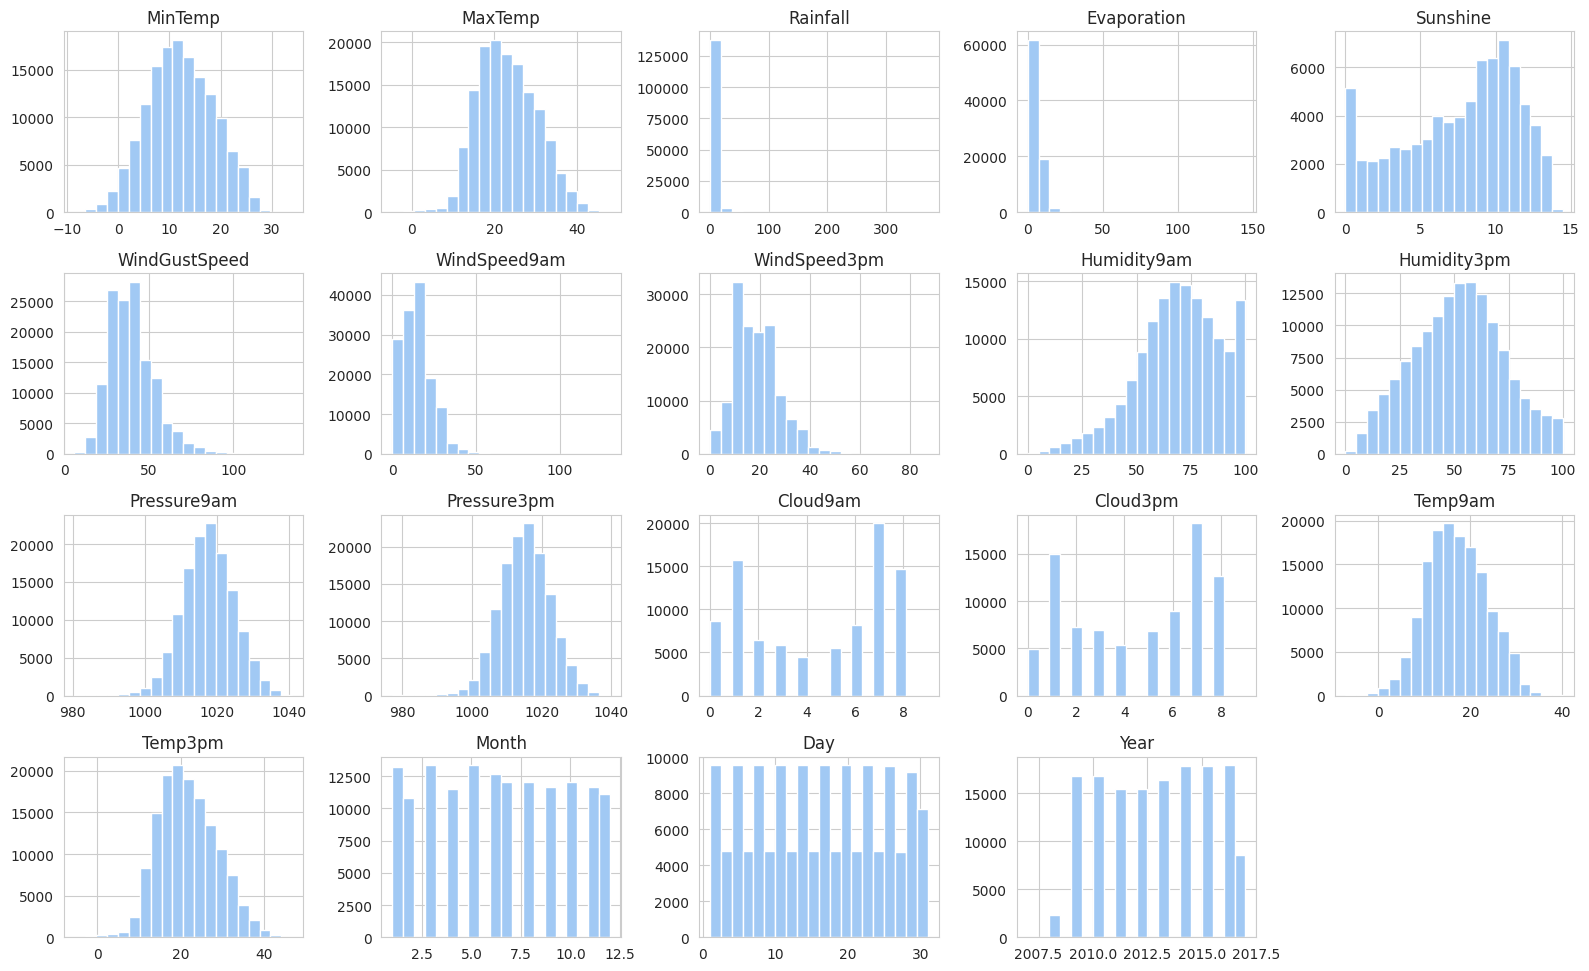

In [92]:
numeric_data = value_types[(value_types['Type'] != 'object') & (value_types['Column'] != 'Date')]
numeric_data = numeric_data['Column'].tolist()

df[numeric_data].hist(figsize=(16, 12), layout=(5, 5), bins=20)
plt.tight_layout()
plt.show()

1. **MinTemp** and **MaxTemp**:

   - The distributions are approximately symmetric and resemble a normal distribution.

2. **Rainfall, Evaporation**:

   - Asymmetrically distributed with a long right tail, where most values are concentrated near zero.

3. **Sunshine**:

   - Right-skewed distribution with multimodality.

4. **WindGustSpeed**, **WindSpeed9am**, and **WindSpeed3pm**:

   - Asymmetric distributions with a left skew, where the majority of values are concentrated towards the lower end of the range.

5. **Humidity9am** and **Humidity3pm**:

   - Dense distribution with slight skewness. Morning humidity distribution is slightly skewed, but overall there are no significant outliers.

6. **Pressure9am, Pressure3pm, Temp9am, Temp3pm**:

   - Both distributions are nearly symmetric and closely resemble a normal distribution.

7. **Cloud9am** and **Cloud3pm**:

   - By nature, these data describe the proportion of the sky covered by cloud.

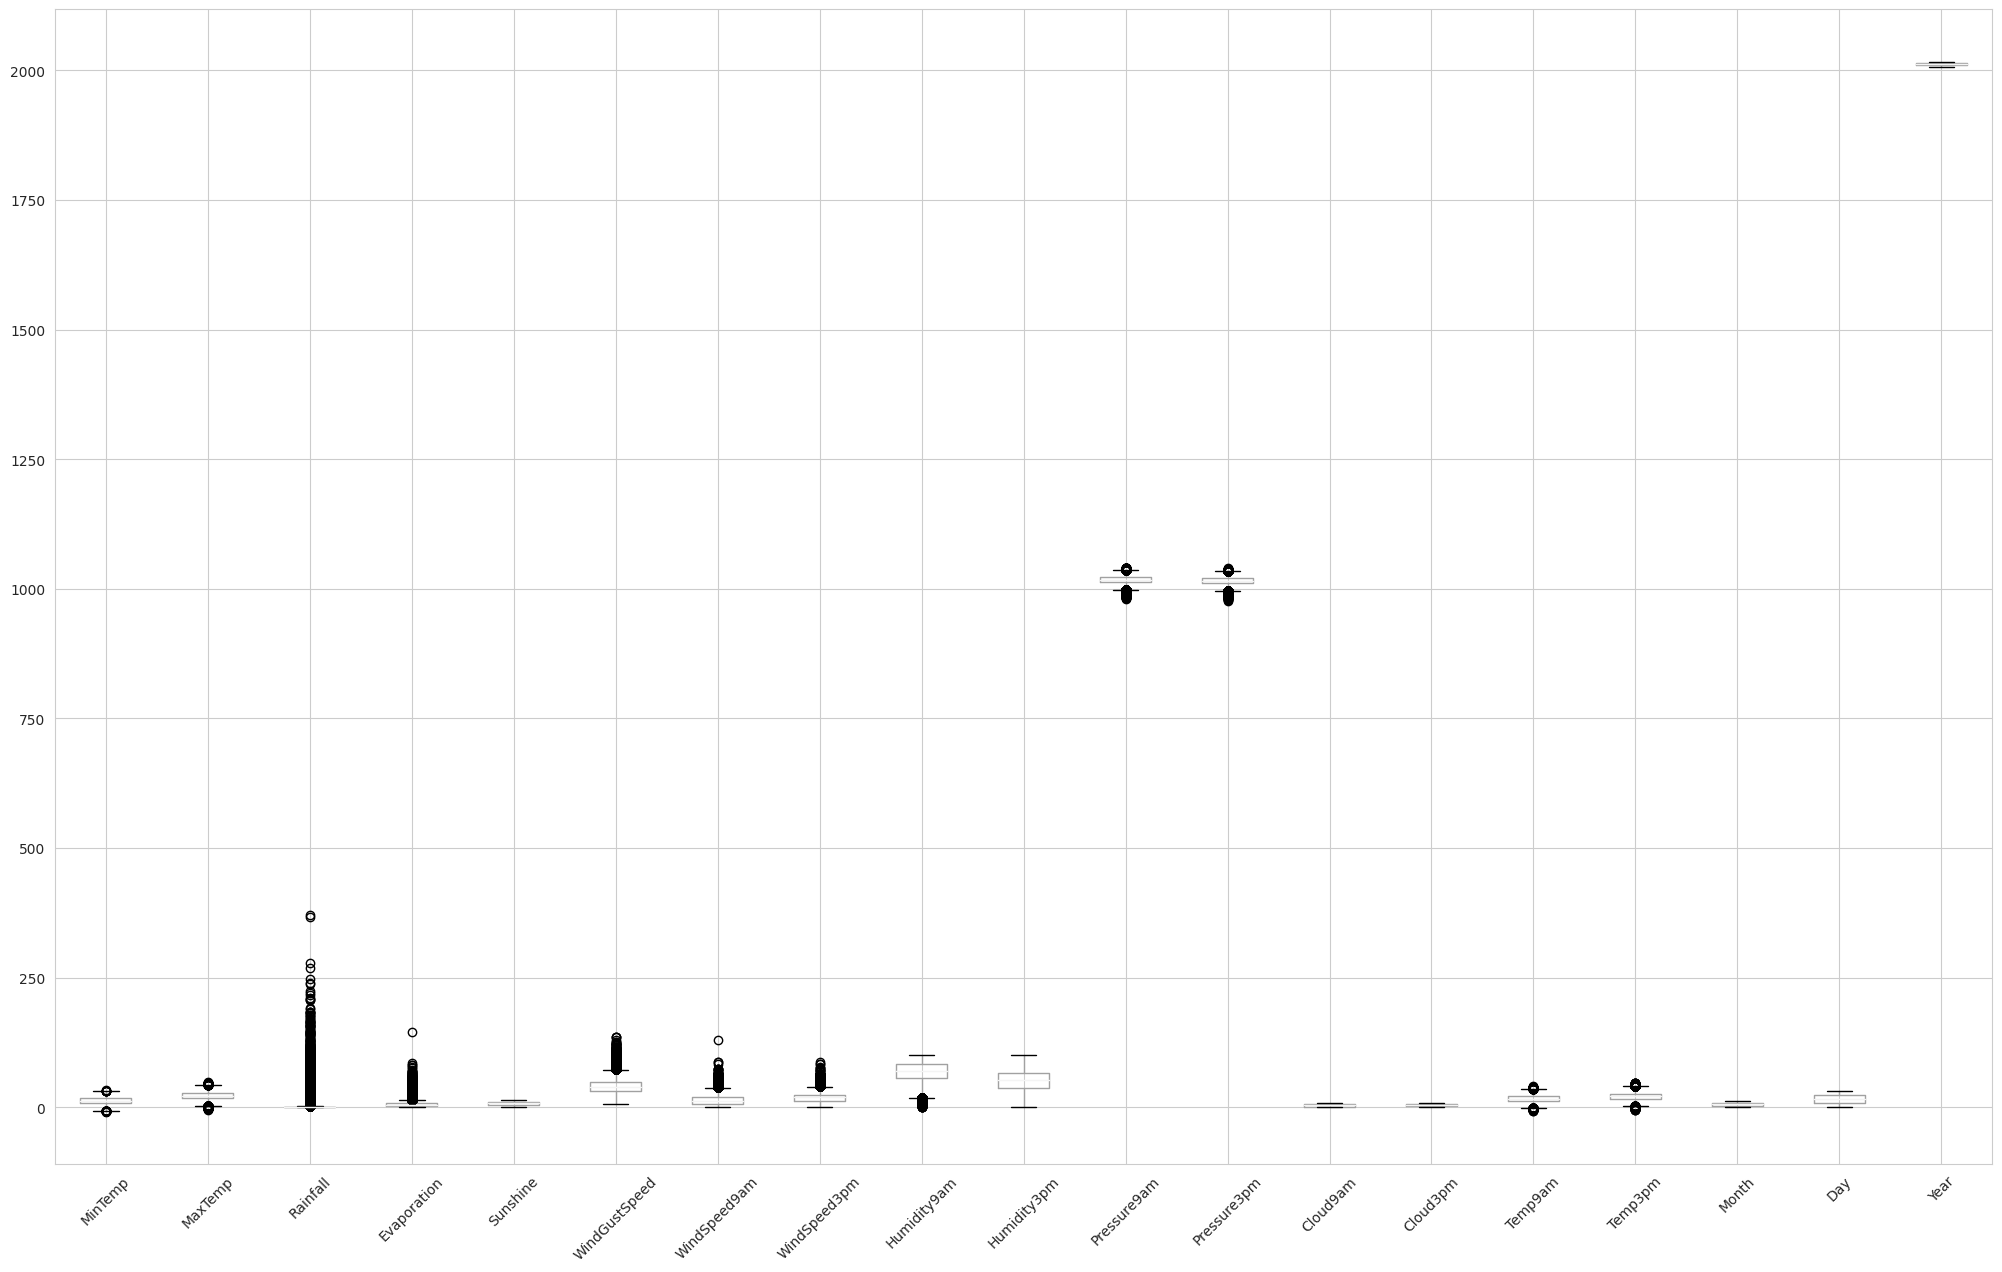

In [93]:
fig = plt.figure()
fig.set_size_inches(25,15)



df.boxplot(column= numeric_data)

plt.xticks(rotation=45)
plt.show()

1. **MinTemp**:

   - The range of values is relatively narrow. There are some outliers, but overall the distribution is stable.

2. **MaxTemp**:

   - Similar to MinTemp, it has a small range of values with occasional outliers.

3. **Rainfall**:

   - A large number of outliers are present, with some values reaching close to 400. This indicates rare but intense rainfall events.

4. **Evaporation**:

   - There are some outliers, though most values fall within a narrow range.

5. **Sunshine**:

   - The distribution is quite dense and stable, with few outliers.

6. **WindGustSpeed**:

   - Outliers are present, indicating strong wind gusts, but the majority of values remain within a small range.

7. **WindSpeed9am** and **WindSpeed3pm**:

   - Both metrics have outliers, although most of the data falls within normal values.

8. **Humidity9am** and **Humidity3pm**:

   - A few outliers are present, especially in the afternoon, but the majority of values remain in a predictable range.

9. **Pressure9am** and **Pressure3pm**:

   - Very stable metrics with minimal outliers.

10. **Cloud9am** and **Cloud3pm**:

   - Values have almost no outliers, indicating stable cloud coverage.

11. **Temp9am** and **Temp3pm**:

   - A small number of outliers, but overall the distribution is fairly even and narrow.


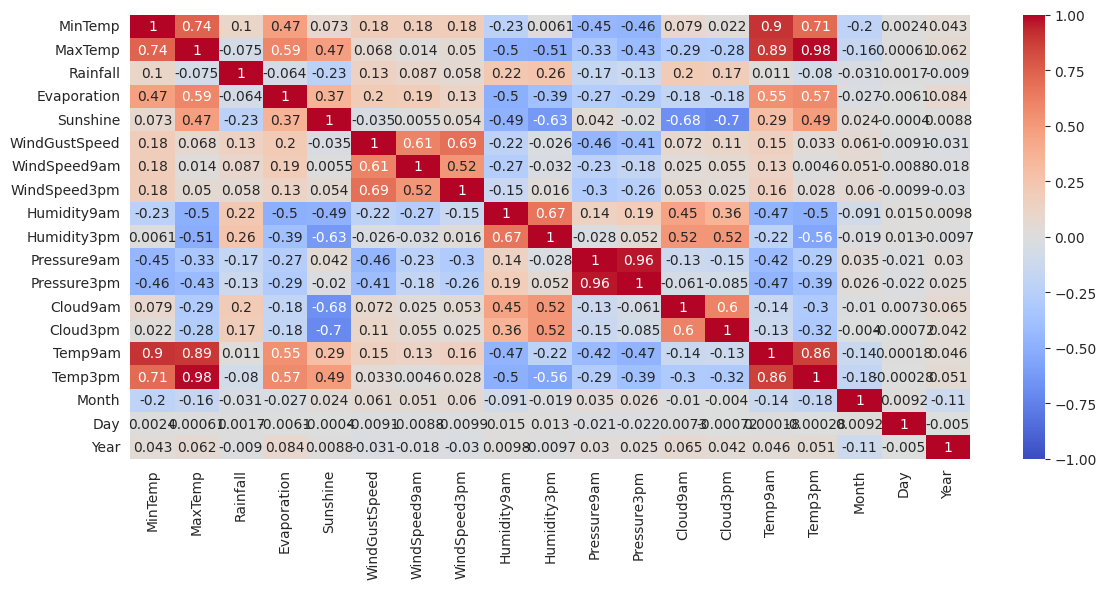

In [94]:
corr = df[numeric_data].corr()

plt.figure(figsize=(12,6))
sns.heatmap(data=corr, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.tight_layout()
plt.show()

### Temperature

- **MinTemp** and **MaxTemp** have a high positive correlation (0.72), indicating that minimum and maximum temperatures generally show similar trends throughout the day.
- **Temp9am** and **Temp3pm** also have high correlations with **MinTemp** and **MaxTemp**, especially **Temp3pm** with **MaxTemp** (0.96), confirming the connection between daily temperatures.

### Pressure

- **Pressure9am** and **Pressure3pm** have a very strong positive correlation (0.94). This suggests that pressure tends to change insignificantly during the day.

### Cloud Cover

- **Cloud9am** and **Cloud3pm** correlate with each other (0.5), indicating similar weather conditions in the morning and afternoon.

### Humidity

- **Humidity9am** and **Humidity3pm** have a high correlation (0.63), suggesting that humidity levels generally remain relatively stable throughout the day.

### Wind Speed

- **WindGustSpeed** and **WindSpeed3pm** have a moderate positive correlation (0.61), indicating some relationship between wind gust speed and wind speed in the afternoon.

### Negative Correlations

- **Humidity3pm** and **MaxTemp** have a negative correlation (-0.49), indicating that higher temperatures are usually associated with lower humidity levels.
- **Pressure9am** and **MaxTemp** also have a negative correlation (-0.33), suggesting that as temperature rises, pressure tends to decrease.

### Other Correlations

- **Evaporation** has a moderate correlation with **MaxTemp** (0.44), which makes sense as evaporation increases with rising temperatures.
- **Sunshine** also correlates with **MaxTemp** (0.37), reflecting the link between sunlight exposure and temperature.



## Fill in missing values

In [95]:
def get_missing_values(data):
  zero_values = data.isna().sum().sort_values(ascending=False)
  zero_values = pd.DataFrame(zero_values)
  zero_values = zero_values.rename(columns={0: 'Amount'})
  zero_values['Percent'] = (zero_values['Amount'] / len(data)) * 100
  zero_values = zero_values.reset_index()
  zero_values = zero_values.rename(columns={'index': 'Column'})



  return zero_values



get_missing_values(df)

,Column,Amount,Percent
0,Sunshine,69835,48.009762
1,Evaporation,62790,43.166506
2,Cloud3pm,59358,40.807095
3,Cloud9am,55888,38.421559
4,Pressure9am,15065,10.356799
5,Pressure3pm,15028,10.331363
6,WindDir9am,10566,7.263853
7,WindGustDir,10326,7.098859
8,WindGustSpeed,10263,7.055548
9,Humidity3pm,4507,3.098446


**Columns with Significant Missing Data:**

- **Sunshine**
- **Evaporation**
- **Cloud3pm**
- **Cloud9am**

*Missing values exceed 15%.*

**Columns with Moderate Missing Data:**

- **Pressure3pm**
- **Pressure9am**
- **WindDir9am**
- **WindGustDir**
- **WindGustSpeed**

*Missing values range between 7% and 10.3%.*

**Columns with Minor Missing Data:**

- In all other columns, missing values are less than 3%.


**Handling Columns with Over 20% Missing Data:**
Columns with over 20% missing values can either be filled using a KNNImputer or removed entirely. We'll try filling them with KNNImputer, as they might contain valuable information.

**Columns: MinTemp, MaxTemp, Temp9am, Temp3pm, Pressure9am, Pressure3pm.**
These columns have approximately normal distributions, so we'll fill missing values with the mean.

**Columns: Humidity9am, Humidity3pm.**
These columns have dense distributions with outliers, so we'll use the median to fill in the missing values.

**Columns: WindGustSpeed, WindSpeed9am, WindSpeed3pm.**
These columns have slightly skewed distributions, so we'll also use the median for imputation.


In [96]:
fill_cols = ['Sunshine', 'Evaporation', 'Cloud9am', 'Cloud3pm']
fill_relevant = [
    'Location', 'Temp9am', 'Temp3pm', 
    'Humidity9am', 'Humidity3pm', 
    'Pressure9am', 'Pressure3pm', 'RainToday'
]

for_fill = (
    pd.get_dummies(df[fill_cols + fill_relevant], columns=['Location'])
    .assign(RainToday=lambda x: x['RainToday'].map({'Yes': 1, 'No': 0}))
)


def impute_chunk(data_chunk):
    imputer = KNNImputer(n_neighbors=3)
    return imputer.fit_transform(data_chunk)

num_chunks = 4
data_chunks = np.array_split(for_fill, num_chunks)

imputed = Parallel(n_jobs=num_chunks)(
    delayed(impute_chunk)(chunk) 
        for chunk in data_chunks
)

imputed_df = pd.DataFrame(
    np.vstack(imputed), 
    columns=for_fill.columns, 
    index=for_fill.index
)

df.update(imputed_df[fill_cols])

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [97]:
def fill_missing_values(df, fill_type, columns):
    df_copy = df.copy()
    for col in columns:
        if fill_type == 'mean':
            if df_copy[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
                mean_value = df_copy[col].mean()
                df_copy[col] = df_copy[col].fillna(mean_value)
                
        elif fill_type == 'median':
            if df_copy[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
                median_value = df_copy[col].median()
                df_copy[col] = df_copy[col].fillna(median_value)
                
        elif fill_type == 'mode':
            mode_series = df_copy[col].mode()
            if not mode_series.empty:
                mode_value = mode_series[0]
                df_copy[col] = df_copy[col].fillna(mode_value)
                
        else:
            raise ValueError(f"Неизвестный тип заполнения: {fill_type}")
    return df_copy

In [98]:
mean_fill = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Pressure9am', 'Pressure3pm']
median_fill = ['Humidity9am', 'Humidity3pm', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Rainfall']
moda_fill = ['WindDir9am', 'WindGustDir', 'WindDir3pm']

df = fill_missing_values(df, 'mean', mean_fill)
df = fill_missing_values(df, 'median', median_fill)
df = fill_missing_values(df, 'mode', moda_fill)

In [99]:
df = df.dropna()

In [100]:
get_missing_values(df)

,Column,Amount,Percent
0,Date,0,0.0
1,Location,0,0.0
2,MinTemp,0,0.0
3,MaxTemp,0,0.0
4,Rainfall,0,0.0
5,Evaporation,0,0.0
6,Sunshine,0,0.0
7,WindGustDir,0,0.0
8,WindGustSpeed,0,0.0
9,WindDir9am,0,0.0


## Generation of new features

In [101]:
df['MaxTempHumidity3pm_Interaction'] = df['MaxTemp'] * df['Humidity3pm']
df['AvgPressure'] = (df['Pressure9am'] * df['Pressure3pm']) / 2
df['AvgWindSpeed'] = (df['WindSpeed9am'] * df['WindSpeed3pm']) / 2
df['EvaporationSunshine_Interaction'] = df['Evaporation'] * df['Sunshine']

df['MonthSin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['MonthCos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['DaySin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['DayCos'] = np.cos(2 * np.pi * df['Day'] / 31)


df = df.drop(columns=['Pressure3pm', 'Temp3pm', 'WindSpeed9am', 'Year', 'Month', 'Day'])

- Since **MaxTemp** and **Humidity3pm** have a significant negative correlation (-0.49), their product may reflect the effect of mugginess, which is crucial for predicting thermal discomfort or extreme conditions.

- The high correlation between **Pressure9am** and **Pressure3pm** (0.94) allows us to combine them into an averaged metric, preserving information about atmospheric pressure throughout the day and reducing redundancy.

- The moderate correlation between **WindSpeed9am** and **WindSpeed3pm** (0.53) makes it reasonable to take their average as an indicator of overall wind strength during the day.

- The moderate correlation between **Evaporation** and **Sunshine** (0.35) suggests that their product could be used as an indicator of evaporation intensity, which is important for analyzing dry conditions.

- Add cyclic features for **Month, Day**

- We will also remove redundant features.


## Preparing data for training

In [102]:
df['RainToday'] = df.RainToday.map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df.RainTomorrow.map({'Yes': 1, 'No': 0})

RainToday and RainTomorrow are originally binary signs indicating the presence of rain as “Yes” or “No”. Let's code them as: 1 for “Yes” and 0 for “No”.

In [103]:
X = df.drop(['RainTomorrow', 'Date'], axis=1)
y = df['RainTomorrow']

X_final_test = X.sample(frac=0.2, random_state=42)
y_final_test = y.loc[X_final_test.index]

X_remaining = X.drop(X_final_test.index)
y_remaining = y.drop(y_final_test.index)

X_train, X_test, y_train, y_test = train_test_split(X_remaining, y_remaining, test_size=0.25, random_state=42)

To test the main model then with the baseline model, I will allocate another 20% of the dataset for an independent final test

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [105]:
def encode_categorical_wind(X_train, y_train, X_test, X_final_test, columns_encode):
  encoder = ce.LeaveOneOutEncoder(columns_encode, sigma=0.1, random_state=42)
  X_train_encoded = encoder.fit_transform(X_train, y_train)
  X_test_encoded = encoder.transform(X_test)
  X_final_test_encoded = encoder.transform(X_final_test)
  return X_train_encoded, X_test_encoded, X_final_test_encoded

In [106]:
columns_encode = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location']
X_train_encoded, X_test_encoded, X_final_test_encoded = encode_categorical_wind(X_train, y_train, X_test, X_final_test, columns_encode)

X_train = X_train_encoded
X_test = X_test_encoded
X_final_test = X_final_test_encoded

The dataset contains several categorical features with a high number of categories, particularly:

- **Location**: 49 categories
- **Wind directions**: 'WindGustDir', 'WindDir9am', 'WindDir3pm', each with 16 categories

To encode these features, I chose **Leave-One-Out Encoding**.

The encoding is implemented in the function *encode\_categorical\_wind*.

Unlike **One-Hot Encoding**, which creates an excessive number of features for high cardinality categories, **Leave-One-Out Encoding** transforms each category into a value that reflects its relationship with the target variable. This approach helps manage high cardinality effectively without significantly expanding the feature space.

The parameter **sigma=0.1** adds a small amount of noise, which plays a crucial role in preventing **data leakage** and **overfitting**.

To further mitigate the risk of data leakage, I first split the data into **training** and **test** sets, and then encoded them **separately**.

In [107]:
over = BorderlineSMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.6)

sampler_pipe = SamplerPipe(steps=[
    ('ov', over),
    ('un', under)
])

X_train_resampled, y_train_resampled = sampler_pipe.fit_resample(X_train, y_train)

Since we have an obvious class imbalance, I used data resampling
Pipeline allows you to sequentially apply first a smaller class increase **(BorderlineSMOTE)** and then a larger class decrease **(RandomUnderSampler)**. This helps to balance the classes

In [108]:
y_train_resampled

unique, counts = np.unique(y_train_resampled, return_counts=True)

count_dict = dict(zip(unique, counts))
print(count_dict)

{0: 38381, 1: 23029}


## Baseline model

As a base model we will try simple logistic regression.

**We will estimate through:** F1-score

In [109]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='saga'))
])


base_model.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(solver='saga'))])

In [110]:
baseline_score = f1_score(y_test, base_model.predict(X_test))
print(f'F1-Score: {baseline_score}')

F1-Score: 0.6355064382033865


In [111]:
print('Baseline model classification report: ')
print(classification_report(y_test, base_model.predict(X_test)))

Baseline model classification report: 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     32820
           1       0.61      0.67      0.64      9417

    accuracy                           0.83     42237
   macro avg       0.75      0.77      0.76     42237
weighted avg       0.84      0.83      0.83     42237



In [112]:
def conf_matrix_visualize(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

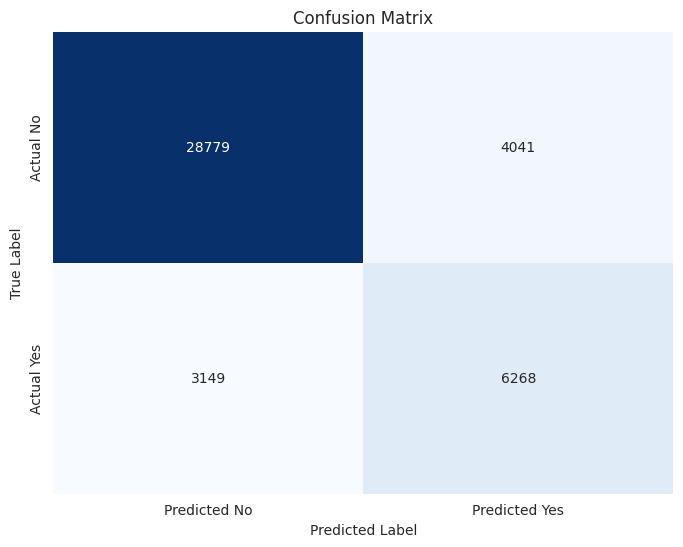

In [113]:
conf_matrix_visualize(y_test, base_model.predict(X_test))

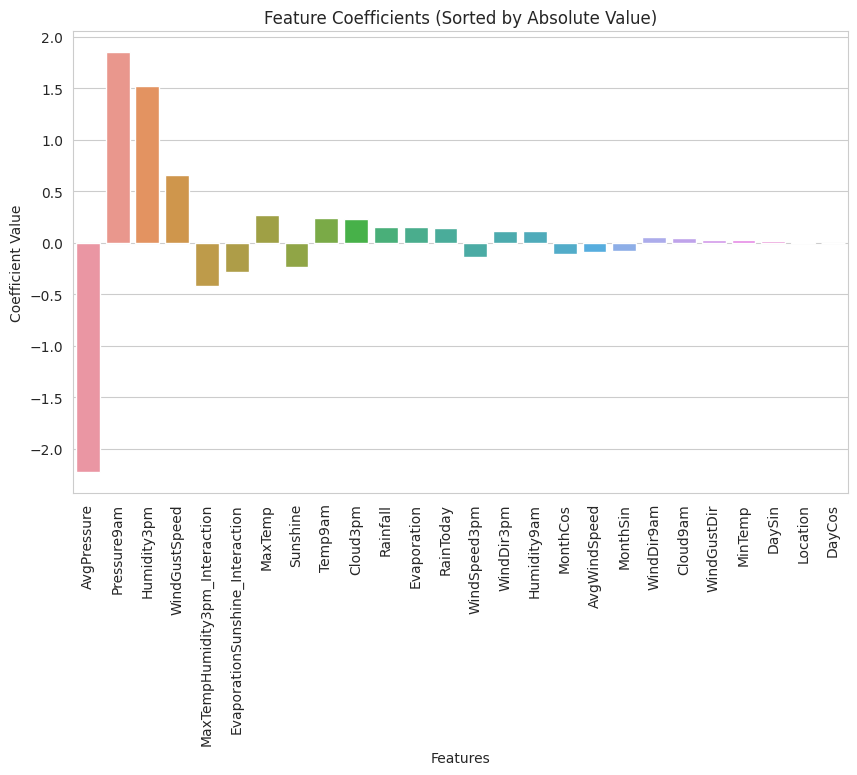

In [114]:
coefs = base_model.named_steps['logreg'].coef_[0]
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefs})

coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Feature', y='Coefficient')
plt.xticks(rotation=90)
plt.title("Feature Coefficients (Sorted by Absolute Value)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.show()

## Testing ensembles: RandomForestClassifier, CatBoostClassifier, XGBoost



For hyperparameter tuning, I use **Optuna**, because it typically works faster than traditional methods like **Grid Search** or **Random Search**.

In [115]:
from sklearn.model_selection import StratifiedKFold

In [116]:
!nvidia-smi

Thu Nov  7 17:07:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             32W /  250W |     293MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [117]:
def cb_params_selection(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'boosting_type': 'Plain',
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bootstrap_type': 'Poisson',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'loss_function': 'Logloss',
        'task_type': 'GPU',
        'gpu_ram_part': 0.7,
        'devices': '0',
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'silent': True 
    }
    
    scores = []
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(X_train_resampled, y_train_resampled):
        X_train_cv = X_train_resampled.iloc[train_index]
        X_test_cv = X_train_resampled.iloc[test_index]
        y_train_cv = y_train_resampled.iloc[train_index]
        y_test_cv = y_train_resampled.iloc[test_index]
        
        model = CatBoostClassifier(**params)
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
        score = f1_score(y_test_cv, y_pred)
        scores.append(score)
        


    return np.mean(scores)

cb_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
cb_study.optimize(cb_params_selection, n_trials=50)

[I 2024-11-07 17:07:33,812] A new study created in memory with name: no-name-fad102e3-7eab-4566-bdf0-e7be26fd05c9
[I 2024-11-07 17:07:55,041] Trial 0 finished with value: 0.7307557457113013 and parameters: {'n_estimators': 499, 'depth': 9, 'learning_rate': 0.007733758933821466, 'l2_leaf_reg': 0.07214562178913428, 'random_strength': 8.521474284938999e-08, 'scale_pos_weight': 3.047871392600218, 'subsample': 0.4489114227889874}. Best is trial 0 with value: 0.7307557457113013.
[I 2024-11-07 17:07:59,469] Trial 1 finished with value: 0.7174503581667858 and parameters: {'n_estimators': 184, 'depth': 6, 'learning_rate': 0.004415969830234078, 'l2_leaf_reg': 2.7899408822515084, 'random_strength': 0.0008067401616664981, 'scale_pos_weight': 1.6271630171317852, 'subsample': 0.6193056081425771}. Best is trial 0 with value: 0.7307557457113013.
[I 2024-11-07 17:08:14,189] Trial 2 finished with value: 0.6429943121814884 and parameters: {'n_estimators': 873, 'depth': 6, 'learning_rate': 0.0029335606839

In [118]:
def xgb_params_selection(trial):

    params = {
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight':  trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'tree_method': 'hist',
        'device': 'cuda' 
    }

    scores = []
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(X_train_resampled, y_train_resampled):
        X_train_cv = X_train_resampled.iloc[train_index]
        X_test_cv = X_train_resampled.iloc[test_index]
        y_train_cv = y_train_resampled.iloc[train_index]
        y_test_cv = y_train_resampled.iloc[test_index]

        model = XGBClassifier(**params)
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
        score = f1_score(y_test_cv, y_pred)
        scores.append(score)
        
    return np.mean(scores)

xgb_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
xgb_study.optimize(xgb_params_selection, n_trials=50)

[I 2024-11-07 17:30:08,333] A new study created in memory with name: no-name-df10bf2d-e522-431a-8d4e-7607d3bc1b83
[I 2024-11-07 17:30:12,072] Trial 0 finished with value: 0.7472258235217789 and parameters: {'n_estimators': 205, 'learning_rate': 0.04239071007311721, 'scale_pos_weight': 3.3989059486692996, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.3693049041902405, 'subsample': 0.8356399673196492, 'colsample_bytree': 0.9840521711754684, 'reg_alpha': 3.4242222190401184, 'reg_lambda': 0.0014471914739771525}. Best is trial 0 with value: 0.7472258235217789.
[I 2024-11-07 17:30:22,465] Trial 1 finished with value: 0.7425568719612928 and parameters: {'n_estimators': 434, 'learning_rate': 0.0038520948464651414, 'scale_pos_weight': 1.8556142855067703, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 2.7066621119375576, 'subsample': 0.6628946504073153, 'colsample_bytree': 0.6439759531253082, 'reg_alpha': 0.007793461641386605, 'reg_lambda': 0.008620071205699744}. Best is trial 0 with value:

In [119]:
def rf_params_selection(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
    }

    scores = []
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(X_train_resampled, y_train_resampled):
        X_train_cv = X_train_resampled.iloc[train_index]
        X_test_cv = X_train_resampled.iloc[test_index]
        y_train_cv = y_train_resampled.iloc[train_index]
        y_test_cv = y_train_resampled.iloc[test_index]

        model = RandomForestClassifier(
            **params,       
            random_state=42,
            n_jobs=-1)
        
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
        score = f1_score(y_test_cv, y_pred)
        scores.append(score)
        
    return np.mean(scores)

rf_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
rf_study.optimize(rf_params_selection, n_trials=50, n_jobs=-1)

[I 2024-11-07 17:37:32,275] A new study created in memory with name: no-name-8fb8ad69-350b-4b6b-9a7b-bc1977215438
[I 2024-11-07 17:38:07,199] Trial 1 finished with value: 0.7382866494452783 and parameters: {'n_estimators': 58, 'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7382866494452783.
[I 2024-11-07 17:38:11,636] Trial 3 finished with value: 0.7313665101291836 and parameters: {'n_estimators': 88, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.7382866494452783.
[I 2024-11-07 17:40:09,033] Trial 0 finished with value: 0.7267838209943286 and parameters: {'n_estimators': 302, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gi

In [120]:
models_params = [ 
    (CatBoostClassifier, cb_study.best_params), 
    (XGBClassifier,  xgb_study.best_params), 
    (RandomForestClassifier, rf_study.best_params)
]

metrics = {
    'F-1': f1_score,
    'ROC_AUC': roc_auc_score,
    'Accuracy': accuracy_score,
    'Balanced Accuracy': balanced_accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score
}


In [122]:
models = []
for model_class, params in models_params:
    model = model_class(**params)
    if isinstance(model, CatBoostClassifier):
        model.fit(X_train_resampled, y_train_resampled, verbose=0)
    else:
        model.fit(X_train_resampled, y_train_resampled)
    models.append(model)

def threshold_param_selection(trial):
    threshold = trial.suggest_float('threshold', 0.1, 0.9)
    f1_scores = []
    for model in models:
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred)
        
        f1_scores.append(f1)

    return np.mean(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(threshold_param_selection, n_trials=50, n_jobs = -1)

best_threshold = study.best_params['threshold']

[I 2024-11-07 18:15:31,434] A new study created in memory with name: no-name-90ef5949-7b90-471e-b36e-8b5b3f18c8ae
[I 2024-11-07 18:15:35,416] Trial 0 finished with value: 0.5340915065482063 and parameters: {'threshold': 0.18131768668879575}. Best is trial 0 with value: 0.5340915065482063.
[I 2024-11-07 18:15:35,457] Trial 3 finished with value: 0.6065152365241836 and parameters: {'threshold': 0.8133227339691574}. Best is trial 3 with value: 0.6065152365241836.
[I 2024-11-07 18:15:35,482] Trial 2 finished with value: 0.5714072444318816 and parameters: {'threshold': 0.2543870309209699}. Best is trial 3 with value: 0.6065152365241836.
[I 2024-11-07 18:15:35,486] Trial 1 finished with value: 0.600748658092945 and parameters: {'threshold': 0.3244627105763769}. Best is trial 3 with value: 0.6065152365241836.
[I 2024-11-07 18:15:39,499] Trial 6 finished with value: 0.6534492462469498 and parameters: {'threshold': 0.7032832964664241}. Best is trial 6 with value: 0.6534492462469498.
[I 2024-11-

In [123]:
model_eval = pd.DataFrame(columns=['Model'] + list(metrics.keys()))

def evaluate_model(model, X_test, y_test, metrics):
    y_pred = [1 if val >= best_threshold else 0 
              for val in model.predict_proba(X_test)[:, 1]]
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = None

    results = {}
    for name, func in metrics.items():
        if name == 'ROC_AUC' and y_proba is not None:
            results[name] = func(y_test, y_proba)
        else:
            results[name] = func(y_test, y_pred)
    return results

for model_class, params in models_params:
    model_name = model_class.__name__

    model = model_class(**params)
    
    if isinstance(model, CatBoostClassifier):
        model.fit(X_train_resampled, y_train_resampled, verbose=0)
    else:
        model.fit(X_train_resampled, y_train_resampled)

    metrics_results = evaluate_model(model, X_test, y_test, metrics)
    
    new_row = pd.DataFrame([{'Model': model_name, **metrics_results}])
    model_eval = pd.concat([model_eval, new_row], ignore_index=True)

model_eval

/tmp/ipykernel_30/3829599064.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_eval = pd.concat([model_eval, new_row], ignore_index=True)


,Model,F-1,ROC_AUC,Accuracy,Balanced Accuracy,Precision,Recall
0,CatBoostClassifier,0.668528,0.893701,0.828515,0.809656,0.587422,0.775619
1,XGBClassifier,0.667938,0.894734,0.826882,0.810498,0.583512,0.780928
2,RandomForestClassifier,0.655878,0.884214,0.845941,0.779108,0.653287,0.658490


In [125]:
best_model = CatBoostClassifier(**cb_study.best_params)
best_model.fit(X_train_resampled, y_train_resampled, silent=True)

## Compare base model with best model

In [132]:
pred_basemodel = base_model.predict(X_final_test)
pred_bestmodel = [1 if val > best_threshold else 0 for val in best_model.predict_proba(X_final_test)[:, 1]]

In [142]:
f1_basemodel = f1_score(y_final_test, pred_basemodel)
f1_bestmodel = f1_score(y_final_test, pred_bestmodel)

print(f'Base model F-1: {f1_basemodel} \nBest model F-1: {f1_bestmodel}')

Base model F-1: 0.6344094189137867 
Best model F-1: 0.671347927853504


In [143]:
print(f'Base model report: \n\n{classification_report(y_final_test, pred_basemodel)}')

Base model report: 

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     21896
           1       0.60      0.67      0.63      6261

    accuracy                           0.83     28157
   macro avg       0.75      0.77      0.76     28157
weighted avg       0.84      0.83      0.83     28157



In [144]:
print(f'Best model report: \n\n{classification_report(y_final_test, pred_bestmodel)}')

Best model report: 

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     21896
           1       0.59      0.78      0.67      6261

    accuracy                           0.83     28157
   macro avg       0.76      0.81      0.78     28157
weighted avg       0.85      0.83      0.84     28157



Base model confusion matrix


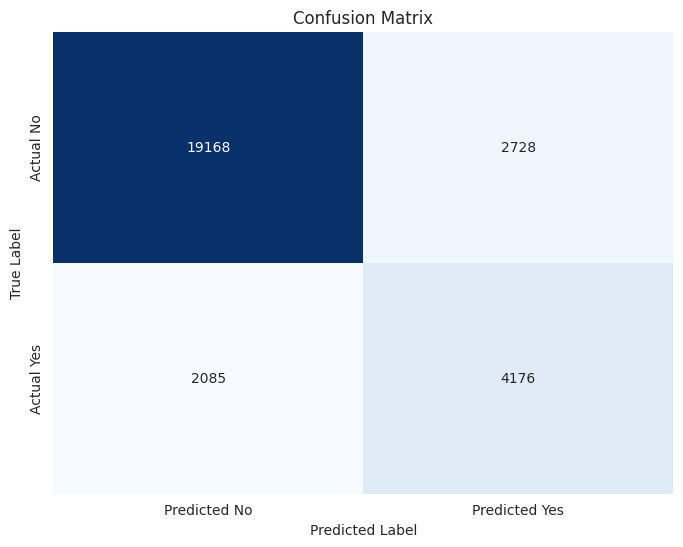

In [145]:
print('Base model confusion matrix')
conf_matrix_visualize(y_final_test, pred_basemodel)

Best model confusion matrix


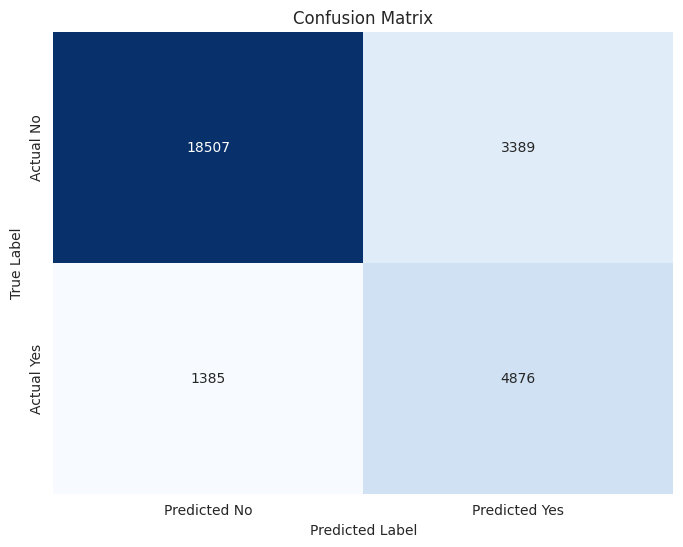

In [146]:
print('Best model confusion matrix')
conf_matrix_visualize(y_final_test, pred_bestmodel)

## Model export

In [147]:
import joblib

joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']